# Lorenz Data Assimilation

Run data assimilation experiments on the Lorenz system equations. This notebook will go through running system equations, generating ensembles and implementing ensemble data assimilation algorithms.

In [1]:
from scripts import utilities as utils
from scripts import lorenz_plotting
from scripts import lorenz_array_prep
from scripts import particle_filter as pf
import numpy as np
from pprint import pprint
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

### Define the basic solution to the Lorenz Equations

The following functions define the basic functions for the Lorenz equations

This is the explicit euler solution applied the Lorenz equations, allowing the solution to be run through time

In [2]:
def explicit_euler(quantity, flux, delta):
    """Use the explicit euler approximation to advance one timestep"""

    new_quantity = quantity + flux * delta

    return new_quantity

def predict(u_ini,v_ini,w_ini,du_dt,dv_dt,dw_dt,rho,psi,beta,delta_t):
    """Advance one timestep by applying explicit euler to the state and derivative"""

    #Explicit euler solution of Lorenz equations
    u = explicit_euler(u_ini,du_dt,delta_t)
    v = explicit_euler(v_ini, dv_dt, delta_t)
    w = explicit_euler(w_ini, dw_dt, delta_t)

    #Lorenz equations
    du_dt = rho * (v - u)
    dv_dt = u * (psi - w) - v
    dw_dt = u * v - beta * w

    return u,v,w,du_dt,dv_dt,dw_dt

def run_lorenz_deterministic(rho_array, psi_array, beta_array, u_ini,v_ini,w_ini,t_array,delta_t):
    """Run Lorenz using the predict function to move forward in time"""

    #Initialize variables and arrays
    u = u_ini
    v = v_ini
    w = w_ini
    du_dt = 0
    dv_dt = 0
    dw_dt = 0
    u_array = []
    v_array = []
    w_array = []

    #Loop through time, solving the lorenz equation
    for i, t in enumerate(t_array):

        #Each time through the loop, advance the model one timestep
        u, v, w, du_dt, dv_dt, dw_dt = predict(u,v,w,du_dt,dv_dt,dw_dt,rho_array[i],psi_array[i],beta_array[i],delta_t)

        u_array.append(u)
        v_array.append(v)
        w_array.append(w)

    state_array = np.vstack([u_array,v_array,w_array])

    return state_array



## Define the settings for the base solution

The settings for the lorenz equation and data assimilation are read from the settings.ini file. 

Note that you can update any of the settings in the python code, with for example settings['num_timesteps'] = 100
Start with number of timesteps, and the base variable settings or initial conditions.

In [10]:
settings = utils.read_settings()
pprint(settings)


INFO:root:The run configuration settings have been read from settings.ini


{'beta_base': 2.6666,
 'beta_mod': 2.6666,
 'beta_var': 0.3,
 'delta_t': 0.01,
 'filter_type': 'pf',
 'meas_freq': 1,
 'measurement_var': 0.5,
 'n_eff': 0.7,
 'num_ens': 500,
 'num_timesteps': 1000,
 'psi_base': 28,
 'psi_mod': 25,
 'psi_var': 0.3,
 'resample_option': 'True',
 'rho_base': 10,
 'rho_mod': 10,
 'rho_var': 0.3,
 'run_enkf': 'True',
 'run_ensembles': 'False',
 'run_pf_sir': 'False',
 'run_pf_sis': 'False',
 'u_ini_base': -10,
 'u_ini_mod': -10,
 'v_ini_base': -15,
 'v_ini_mod': -15,
 'w_ini_base': 10,
 'w_ini_mod': 10}


In [11]:

logging.info('Preparing arrays for initial runs')
t_array                                         = lorenz_array_prep.create_time_array(settings)
rho_base_array, psi_base_array, beta_base_array = lorenz_array_prep.create_parameter_arrays(settings, 'base')
rho_mod_array, psi_mod_array, beta_mod_array    = lorenz_array_prep.create_parameter_arrays(settings, 'mod')


INFO:root:Preparing arrays for initial runs


INFO:root:First performing base model run.
INFO:root:Log test


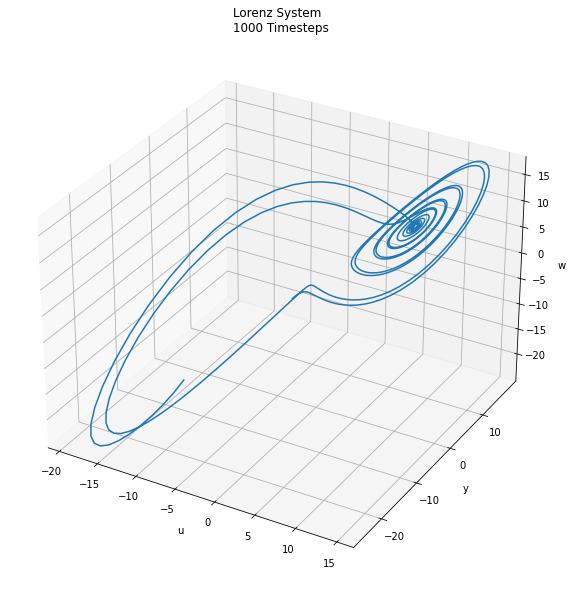

In [12]:
logging.info(f'First performing base model run.')
state_array_base_run = run_lorenz_deterministic(rho_base_array, psi_base_array, beta_base_array,
                                  settings['u_ini_base'],settings['v_ini_base'],settings['w_ini_base'],
                                  t_array, settings['delta_t'])

lorenz_plotting.plot_3D_lorenz(settings,state_array_base_run)

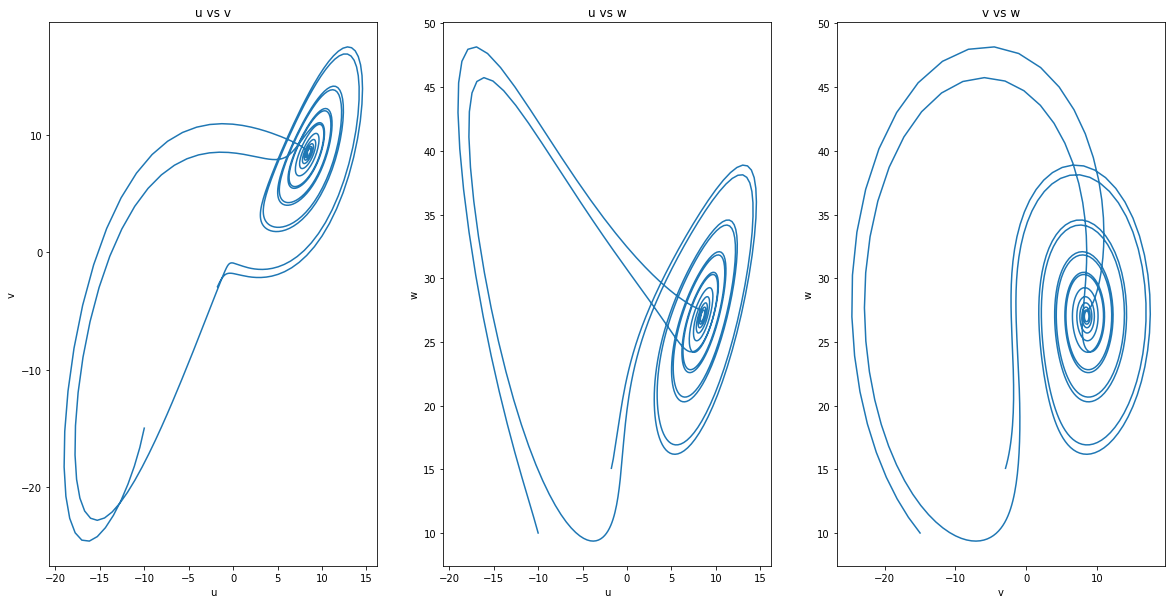

In [6]:
lorenz_plotting.plot_lorenz_basis(state_array_base_run)

In [7]:
logging.info('Create ensemble of arrays, based on prescribed parameter variance')
rho_ens_array, psi_ens_array, beta_ens_array = lorenz_array_prep.create_ens_arrays(settings)

logging.info('Generating measurements at the desired frequency')
meas_array = lorenz_array_prep.create_measurement_array(settings, state_array_base_run[0][:])


INFO:root:Create ensemble of arrays, based on prescribed parameter variance
INFO:root:Generating measurements at the desired frequency
